In [69]:
import sys
sys.path.insert(0, '..')

In [70]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [71]:
wid = 64
oversample = 4

nwavels = 30
npoly=5

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


files = [
    'n8yj53vfq_cal.fits'

]

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid) for file in files]

exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid) for file in files]

Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj53vfq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj53vfq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71  

In [72]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
    "bias": {},
    "jitter": {},
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 0.1#7/43*oversample

model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [73]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*30, 0),
    "spectrum": opt(g*30, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*5000, 20),
    "cold_mask_rot": opt(g*2000, 50),
    "bias": opt(g*30, 60),
    #"jitter": opt(g*10, 70),
    #"cold_mask_scale": opt(g*3000, 150),
    #"cold_mask_shear": opt(g*1000, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    "aberrations": opt(g*100,80, (500, 2)),#, (150, g*0.2)),
    #"spectrum": opt(g*50, 20)#, (150, g*200), (200, g*300), (250, g*400)),
    #"spectrum": opt(g*0.01, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    "rot": opt(g*1000, 70),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [74]:
losses, models = optimise(params, model_single, exposures_single, things, 1000)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

{'n8yj53vfq': {'positions': Array([[ 1.7581379e+08, -5.1891564e+07],
       [-5.1891592e+07,  1.6768384e+08]], dtype=float32), 'spectrum': Array([[ 3.9211963e+09, -2.9486374e+08,  1.4166555e+09, -1.5650957e+08,
         9.1825254e+08],
       [-2.9486378e+08,  3.8231050e+08, -1.3635090e+08,  2.4278104e+08,
        -9.2861848e+07],
       [ 1.4166554e+09, -1.3635091e+08,  6.1345376e+08, -7.9507632e+07,
         4.2554205e+08],
       [-1.5650955e+08,  2.4278107e+08, -7.9507608e+07,  1.8190867e+08,
        -5.6679376e+07],
       [ 9.1825242e+08, -9.2861864e+07,  4.2554208e+08, -5.6679408e+07,
         3.0866992e+08]], dtype=float32), 'cold_mask_shift': Array([[-6813612.5 ,   759605.2 ],
       [  759605.44, -6812010.  ]], dtype=float32), 'cold_mask_rot': Array([[-12341571.]], dtype=float32), 'bias': Array([[12637163.]], dtype=float32), 'aberrations': Array([[-7.25994775e+03,  7.16997009e+02, -1.08838005e+02,
         1.99379114e+03, -1.99410535e+03, -1.85467010e+02,
        -2.18309357e

  0%|          | 0/1000 [00:00<?, ?it/s]

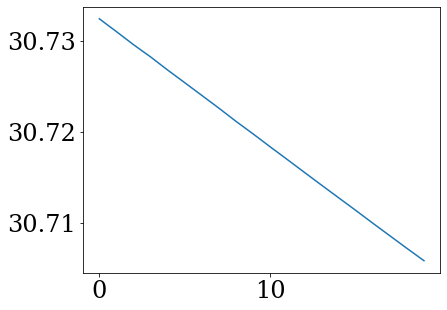

In [75]:
plt.plot(np.asarray(losses[-20:])/wid**2)

7


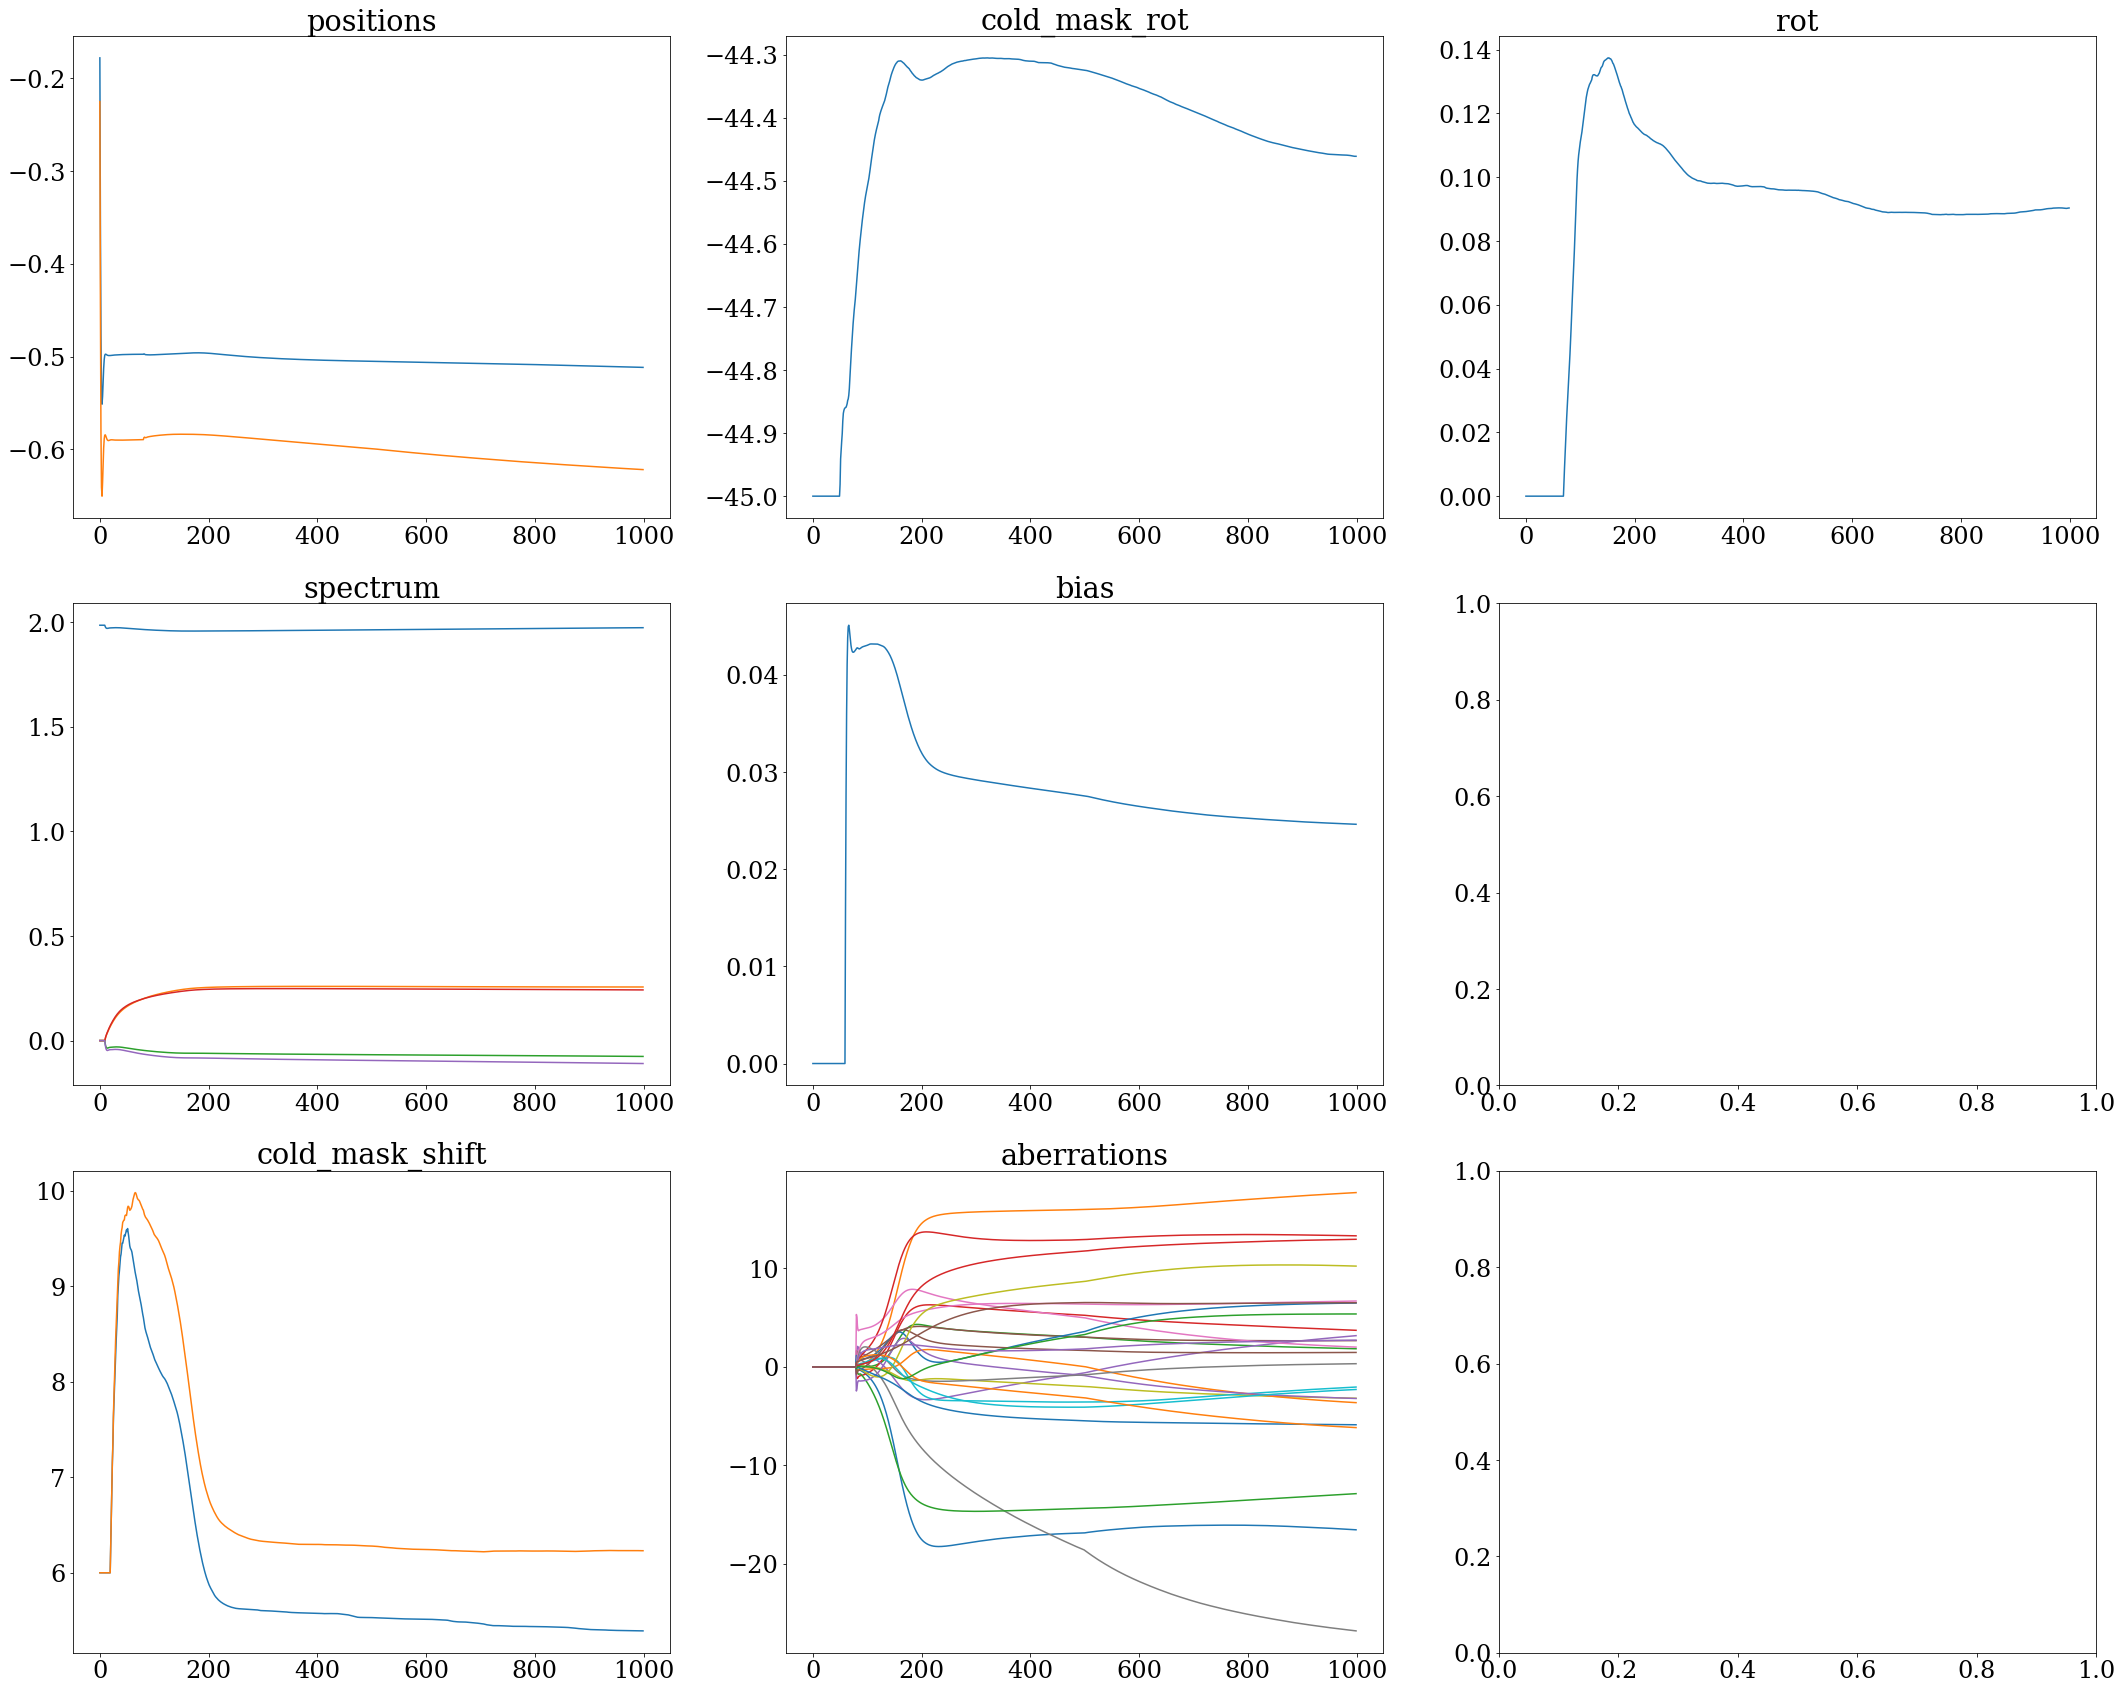

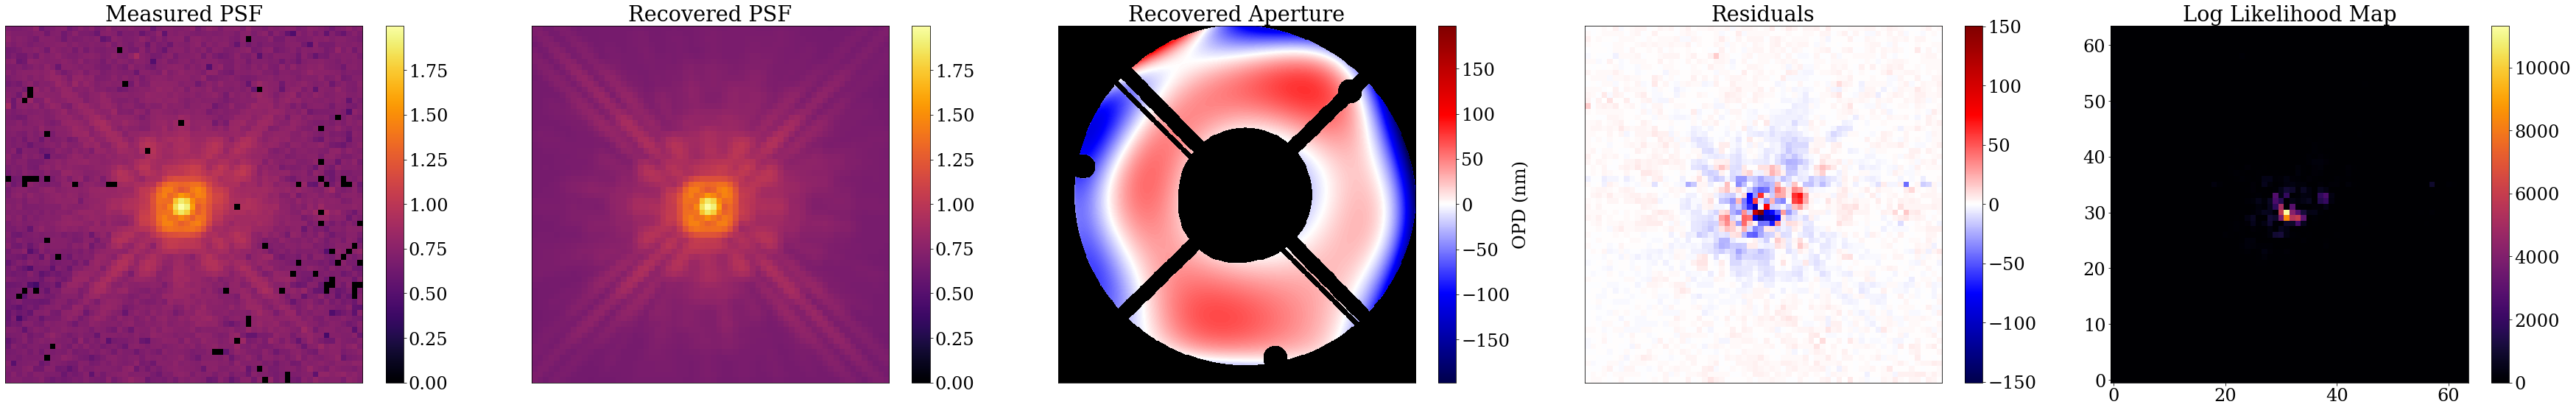

In [76]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)